In [41]:
library(ggplot2)
library(comprehenr)
library(tree)
library(ISLR2)
library(caret)
library(dplyr)
library(tree)
library(randomForest)
library(e1071)

fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}
fig(14,10)

set.seed(0)

## Question 2
Here, I use the list comprehension library for compactness. Here it parses over each item in X.1 and X.2, checks the condition and returns an output generated from the appropriate distribution
the idea is that when the tree looks at this data and does it's splitting, it will identify and group the Y observations based on the logical conditions
and return the variance of that group.


In [4]:
results <- c()
for (i in 1:10000){
X.1 <- runif(100, 0, 10)
X.2 <- runif(100, -4, 4)
temp <- data.frame( X.1 = X.1, X.2 = X.2, #generates sample data from uniform dist. within ranges
                    Y = to_vec(for (i in 1:100) #loops through x.1 and x.2
             # below lines assigns a variable from the normal distribution with location and scale for each condition
            if (X.1[i]<5) rnorm(1, mean = 0, sd = 1)
            else if (X.1[i] >= 5 & X.2[i] >=0) rnorm(1, mean = 5, sd = 1) 
            else if (X.1[i] >= 5 & X.2[i] <0) rnorm(1, mean = -5, sd = 1) 
                          )
                    )
    tree.fit <- tree(Y~., data = temp, mindev = 0) #fitting tree to data 
    results <- append(results, tree.fit$frame$var[1])  
    }
winner <- mean(results == "X.2") #turns each entry where condition is true to 1 and 0 otherwise and takes the mean.
winner

[1] 1

## Question 3

In [177]:
errors = data.frame(pm.1 = seq(from = 0.001, to = 1, by = 0.001),
                    pm.2 = 1-pm.1, 
                    Classification.Errors = 1 - pmax(pm.1,pm.2),
                    Entropy = -(pm.1*log(pm.1)+(pm.2)*log(pm.2)), #calculating entrooy
                    Gini.Index = 2*pm.1*(1-pm.1) #calculating gini index. this formula has been simplified from a sum
                   )

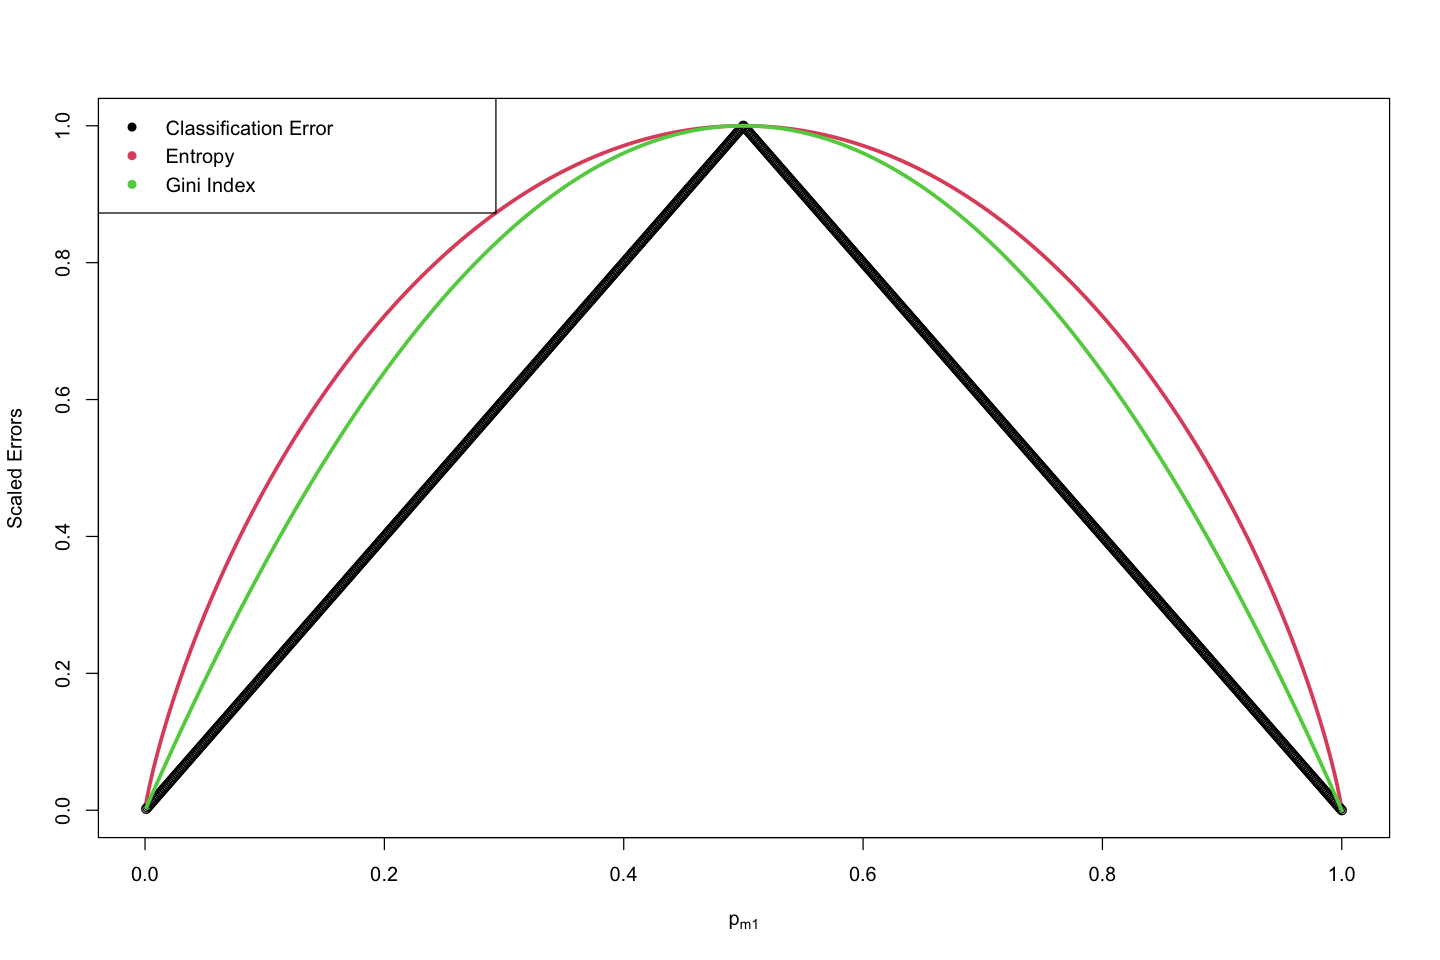

In [178]:
plot(errors$pm.1, errors$Classification.Errors/max(errors$Classification.Errors),
     ylab = 'Scaled Errors',
     xlab = expression(p[m][1]),
     col = 1)
lines(errors$pm.1, errors$Entropy/max(errors$Entropy, na.rm = TRUE), col = 2, lwd = 3)
lines(errors$pm.1, errors$Gini.Index/max(errors$Gini.Index), col = 3, lwd = 3)
legend("topleft", legend = c("Classification Error", "Entropy", "Gini Index"), col= 1:3, , cex=1, pch=16)

## Question 5

In [8]:
#importing dataset
car.seats <- Carseats

### Question 5.1

In [9]:
#splitting data
idx <- sample(seq(1, 3), size = nrow(car.seats), replace = TRUE, prob = c(.6, .2, .2))

train <- car.seats[idx == 1,]

test <- car.seats[idx == 2,]

val <- car.seats[idx == 3,]
actuals <- car.seats$Sales

### Question 5.2 - Vanilla Tree
#### This tree has a test MSE of 4.1412

In [10]:
tree.fit <- tree(Sales~. , data=train, mindev=0) #training model on training data

MSE <- RMSE(predict(tree.fit,test), test$Sales)^2 #testing model predictive ability on test data (unseen) and caculating MSE
MSE

[1] 4.141161

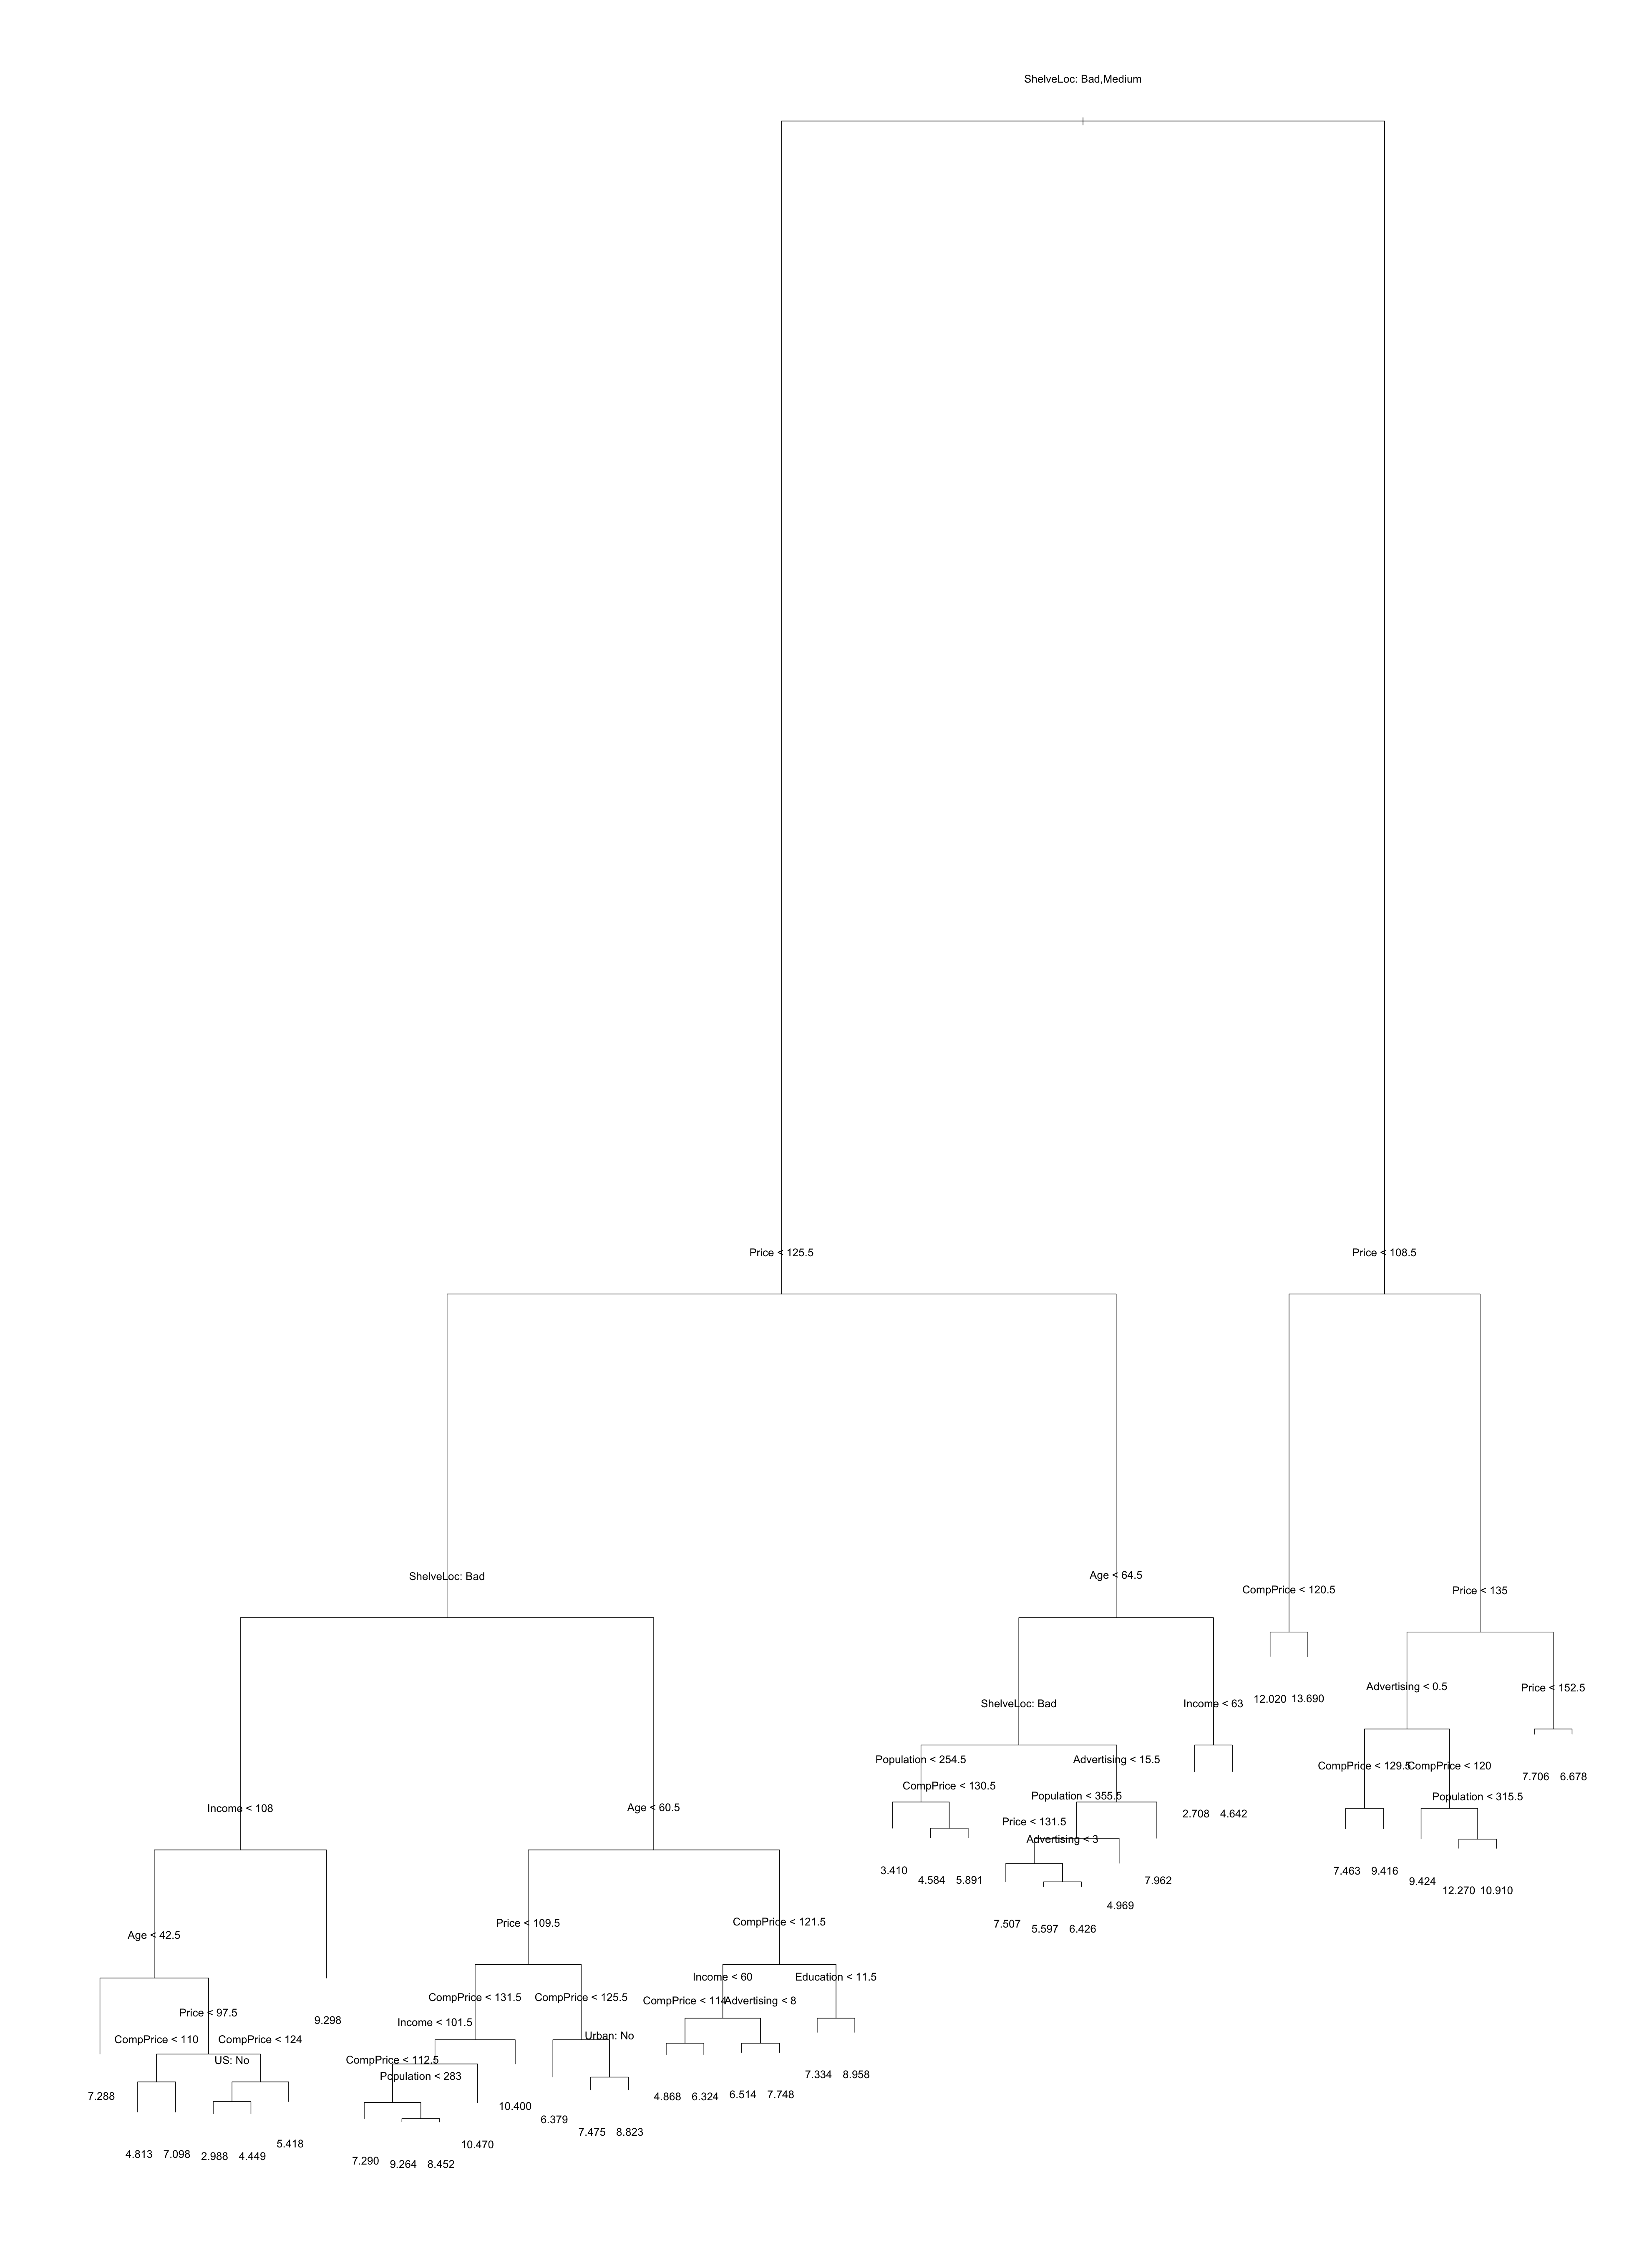

In [11]:
plot(tree.fit)
text(tree.fit, pretty = 0, cex = 1.3)

### Question 5.3 - Pruned Tree
#### This tree has a test MSE of 5.1901. Its MSE is actually higher than the original than that of the original tree. Thus, pruning the tree did not improve the performance of this tree.

In [95]:
cv.tree.fit <- cv.tree(tree.fit, K=10, FUN = prune.tree) #prunning tree

optim.tree.size <- cv.tree.fit$size[which.min(cv.tree.fit$dev)] #optimal pruned tree

pruned.tree.fit <- prune.tree(tree.fit, best = optim.tree.size)

MSE <- RMSE(predict(pruned.tree.fit,test), test$Sales)^2 #testing model predictive ability on test data (unseen) and caculating MSE

MSE

[1] 5.190139

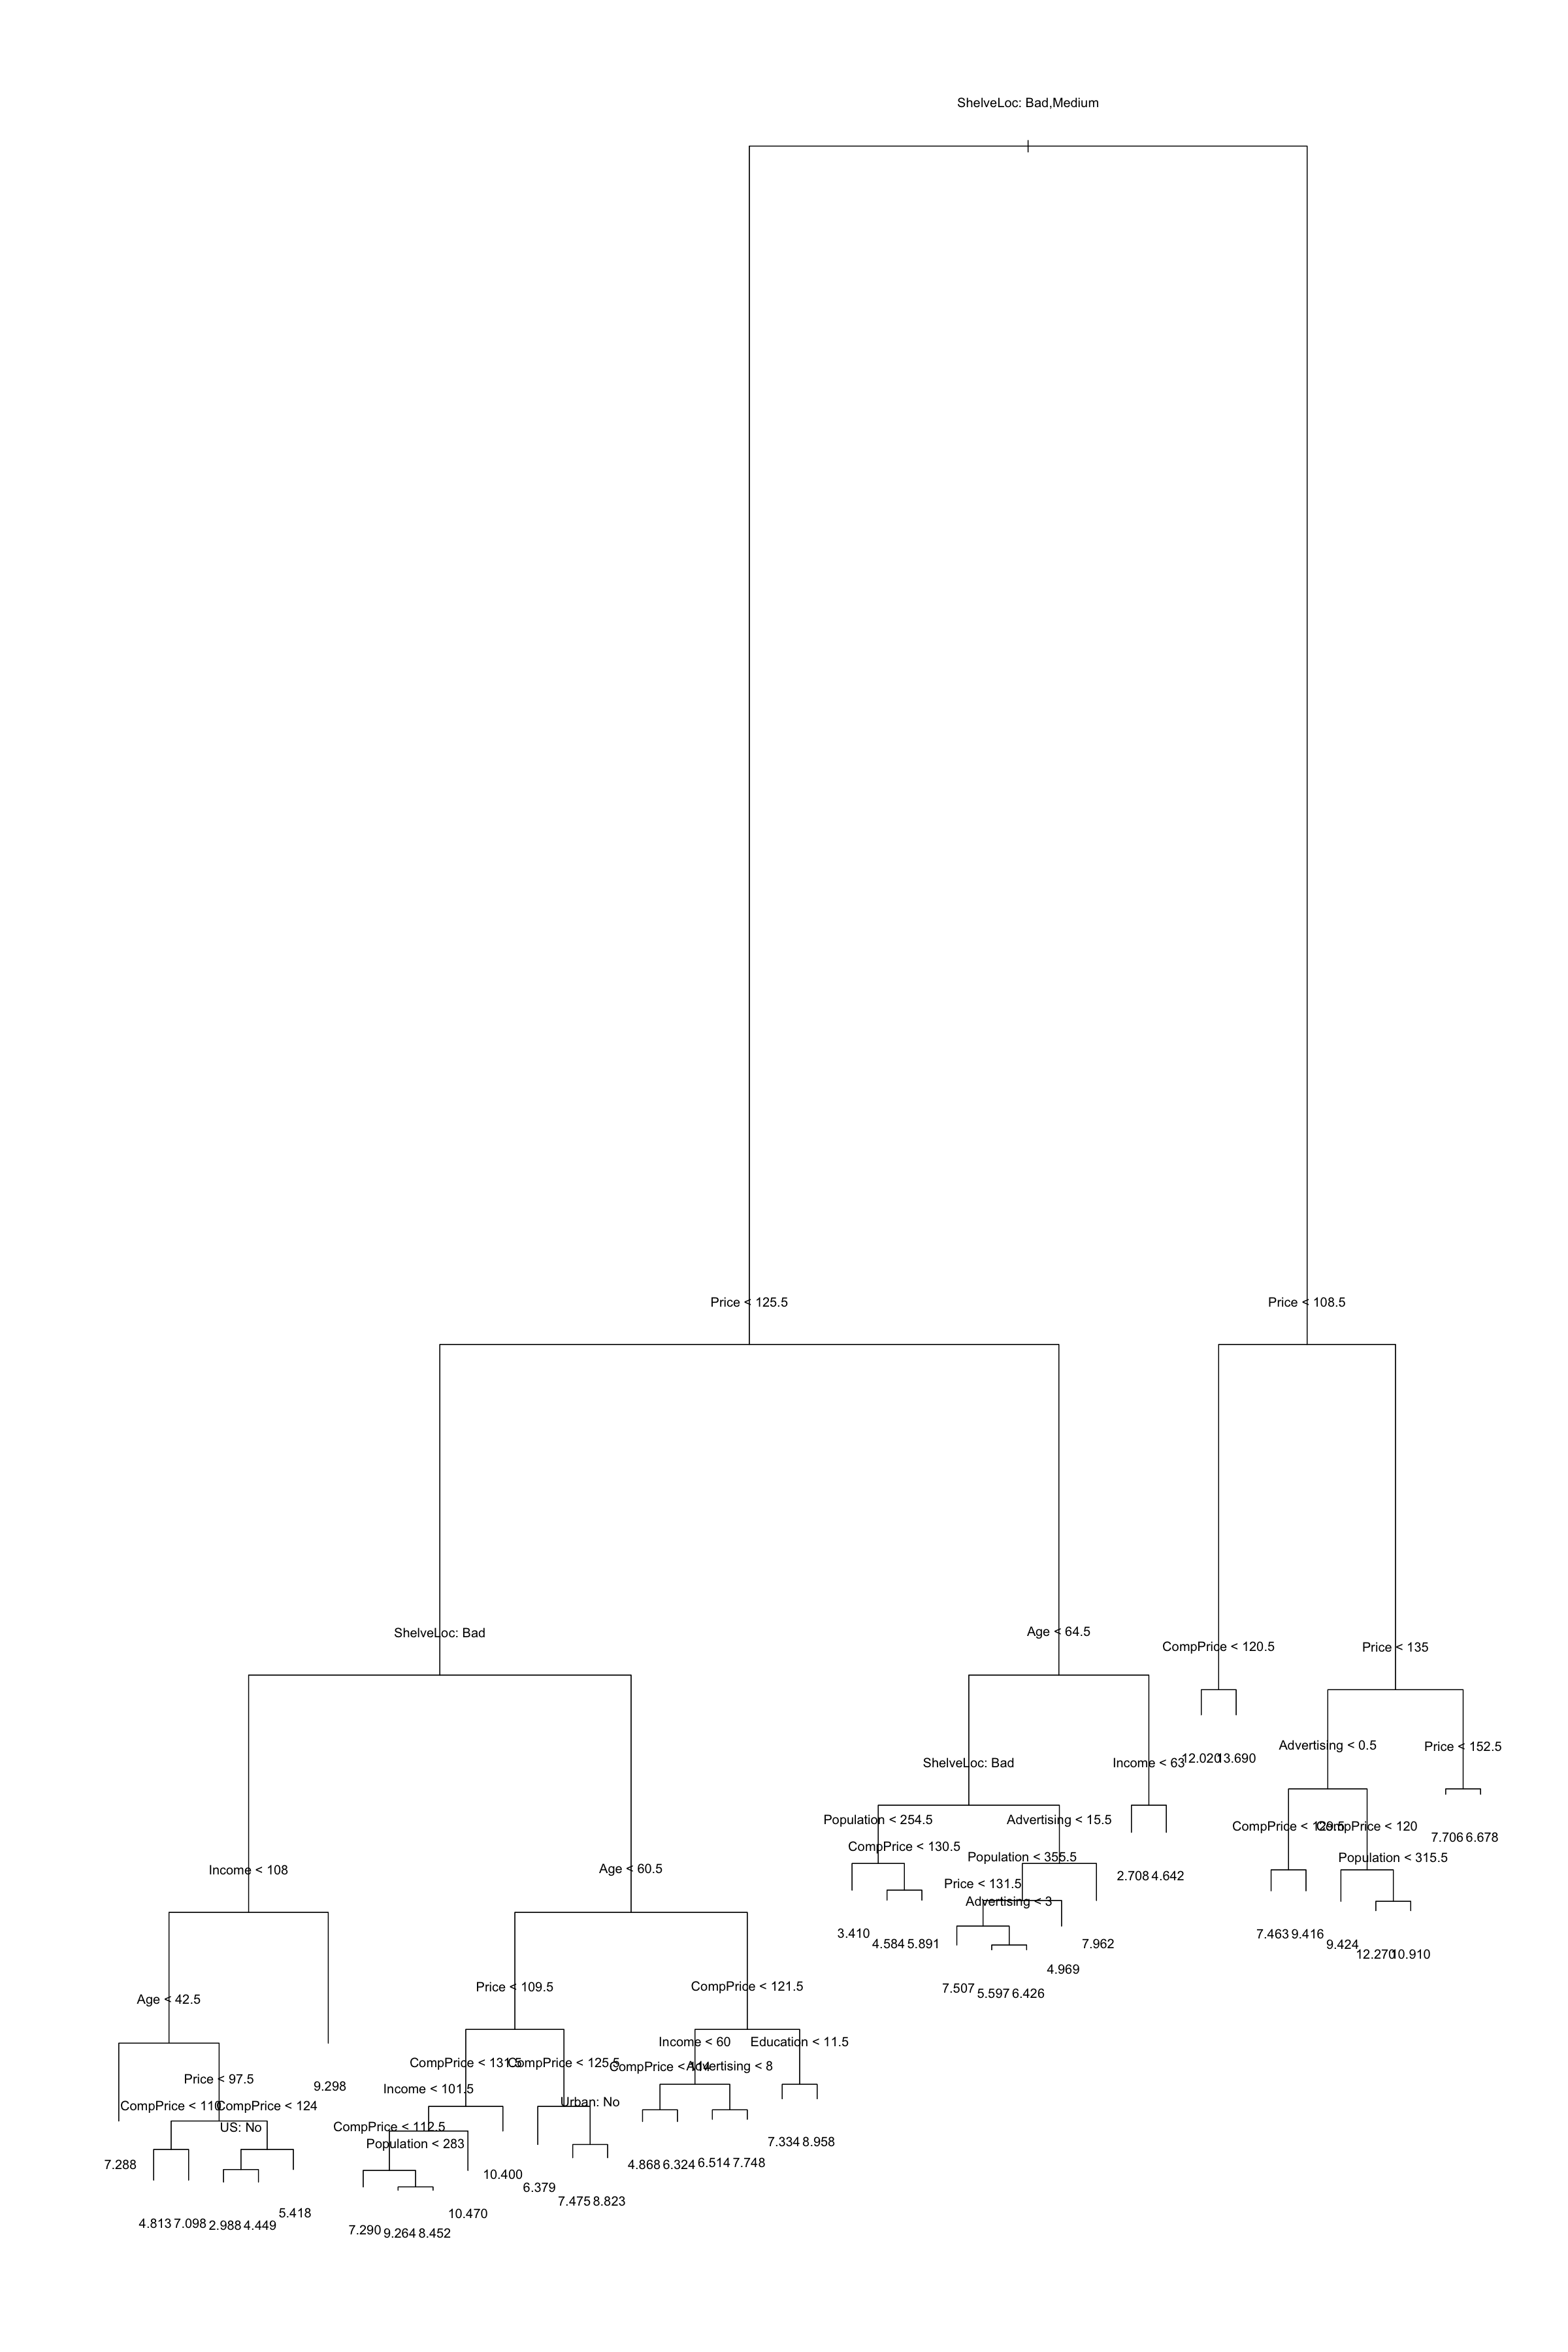

In [71]:
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}
fig(20,30)


plot(pruned.tree.fit)
text(pruned.tree.fit, pretty = 0, cex = 1)

### Question 5.4 - Bagged Tree
#### Using bagging, the MSE for this model (2.7023) is significantly better than the previous two models. Similarly, based on the results of the importance function, we observe that the most significant variables in this regression are the Price and ShelveLoc variable

In [25]:
bagged.tree <- randomForest(Sales~. , data = train, mtry = 10, importance = TRUE)
MSE <- RMSE(predict(bagged.tree,test), test$Sales)^2

importance(bagged.tree)
MSE

,%IncMSE,IncNodePurity
CompPrice,26.06981595,181.450133
Income,9.46857294,131.270533
Advertising,18.88132047,151.693591
Population,-1.05328935,73.259676
Price,62.17916868,550.546844
ShelveLoc,76.57125351,720.048441
Age,15.91838496,162.242221
Education,0.39168645,41.160794
Urban,0.01946072,8.493951
US,3.67032387,11.918975


[1] 2.702325

### Question 5.5 - Random Forests
#### Using random forest, the MSE for this model (2.7933) is significantly better than the two vanilla and pruned trees. Howver, it performs marginally worse than the bagged tree. Similarly, based on the results of the importance function, we observe that the most significant variables in this regression are still Price and ShelveLoc variable by node purity. However, the importance of the ShelveLoc variable fell significantly in node purity relative to its value in the bagged model. We also see that as the number of predictors increases, the error decreases exponentially.

In [26]:
rf.fit <- randomForest(Sales~. , data = train, importance = TRUE)
MSE <- RMSE(predict(rf.fit,test), test$Sales)^2

importance(rf.fit)
MSE

,%IncMSE,IncNodePurity
CompPrice,15.516146,177.20275
Income,5.205948,167.97574
Advertising,15.090243,158.18757
Population,-2.469815,117.91750
Price,37.811051,457.82163
ShelveLoc,44.926036,519.01995
Age,16.219032,239.38401
Education,1.404743,85.99942
Urban,0.674324,19.91502
US,4.528157,26.22641


[1] 2.793391

In [33]:
error <- c() #initiating empty list

for (i in 1:9){ #loops through amount of predictors used in random forest. I excluded 10 because that is just bagging
    temp.fit <- randomForest(Sales~. , data = train, mtry = i, importance = TRUE) #generating temp model
    error <- append(error,RMSE(predict(temp.fit,test), test$Sales)^2) #calculating and storing MSE of model for each i
    }

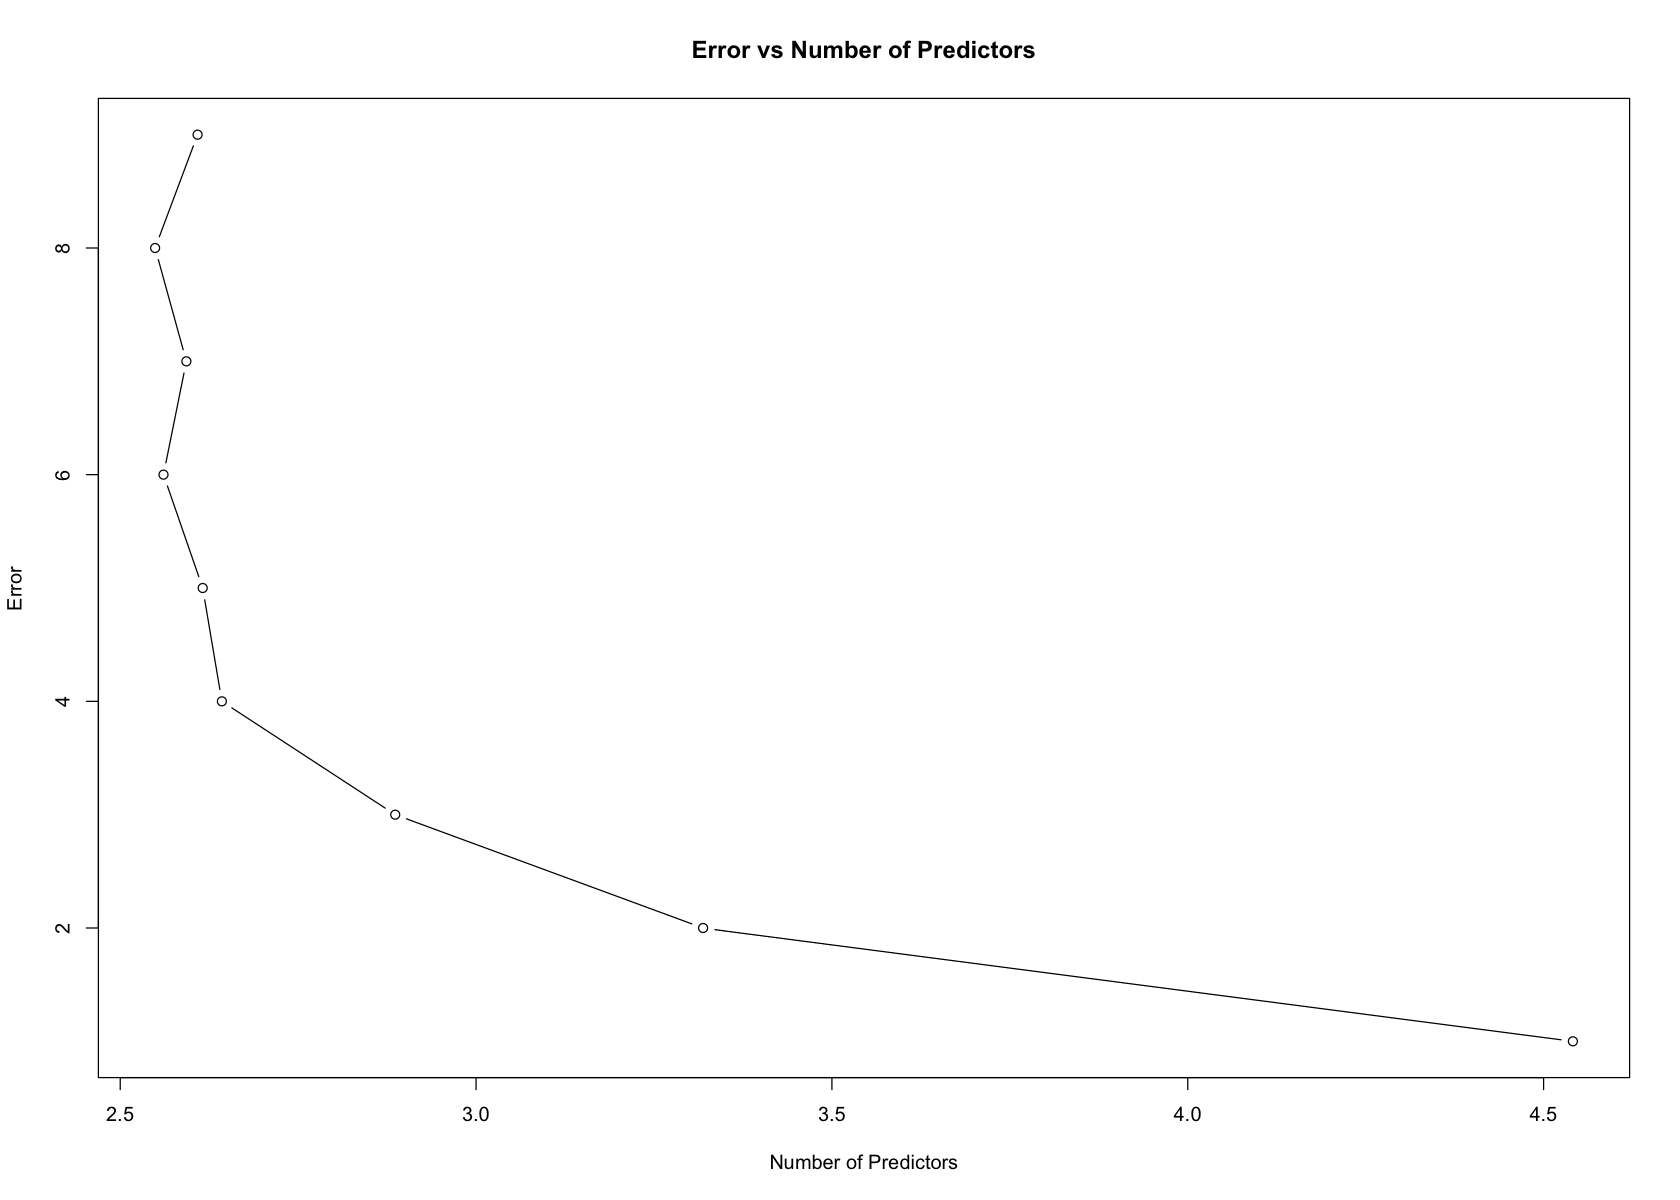

In [40]:
plot(error,1:9, ylab = "Error", xlab = "Number of Predictors", main = "Error vs Number of Predictors", type = "b")

### Question 5.6 - Support Vector Machines
#### After tuning the SVM and finding the optimal cost and gamma to be 100 and 0.0025, respectively, this model produced a MSE of 1.2020, the lowest of all the models produced. Similarly, I choose the radial kernel because the carseat data has a high number of dimensions and the radial kerner computres infinite dimensional dot products required for the transformation. It also does this in an extremely efficient manner via Taylor Expansions. 

In [52]:
svm.fit <- svm(Sales~., data = train, kernel = "radial", cost =1 , gamma = 1) #training svm and guessing intitial parameters

#tuning model by testing parameters. This function returns the ideal tuning for the model
tuned.fit<-tune(svm, Sales~., data = train,, kernel="radial",
                ranges=list(cost=c(.001, .01,0.1,1,10,100,1000),
                            gamma=c(0.01,0.1, 0.25, 0.5,1,2,3,4, 1/dim(car.seats)))
               )


Call:
svm(formula = Sales ~ ., data = train, kernel = "radial", cost = 1, 
    gamma = 1)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  1 
    epsilon:  0.1 


Number of Support Vectors:  231


In [60]:
#pulling optimal parameters from tuning process
optim.tune <- tuned.fit$best.parameters

#fitting model with new parameters
svm.tuned <- svm(Sales~., data = train, kernel = "radial", cost = optim.tune[1] , gamma = optim.tune[2])

#calculating MSE of tuned model
MSE <- RMSE(predict(svm.tuned,test), test$Sales)^2
MSE

[1] 1.202074

### Question 5.7 - Testing SVM (best model by MSE) on Validation Set
#### The results of this test show that both pruned and the vanilla tree have the same MSE, however, the SVM model still perform significantly better than all other models with a much lower error.

In [94]:

data.frame( Model = c("Vanilla Tree", "Pruned Tree", "Bagged Tree", "Random Forest", "Support Vector Machine"),
            `Validation MSE` = c(RMSE(predict(tree.fit,val), val$Sales)^2,
                                  RMSE(predict(pruned.tree.fit,val), val$Sales)^2,
                                  RMSE(predict(bagged.tree,val), val$Sales)^2,
                                  RMSE(predict(rf.fit,val), val$Sales)^2,
                                  RMSE(predict(svm.tuned,val), val$Sales)^2
                                 )                   
           )
    

Model,Validation.MSE
<chr>,<dbl>
Vanilla Tree,4.639638
Pruned Tree,4.639638
Bagged Tree,2.826637
Random Forest,2.783357
Support Vector Machine,1.426967


### Question 5.8 - Discussion
#### As stated in the previous question, the SVM model performed the best, however, this was only after the model was tuned. Moreover, this model is the least interpretable model of the models tested. The vanilla and pruned tree had similar performances and also perform the worst of all the models. Yet, the pruned tree is the most intepretable model as it can visualize how the decisions were made and what variables impact each decision. Personally, I would choose the SVM model if there was particular emphasis on the raw perfomance of the model. Otherwise, I would always choose the Random Forest model, because though it is not as easily intepretable as the Pruned Tree, it is much more interpretable than the SVM and simultaneously performs relatively well with the second lowest MSE. Furthermore, it performed the best with the least amount of tuning, making it an ideal choice as it offers excellent performance with moderate interpretability out of the box.